In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
gpus = tf.config.experimental.list_physical_devices(device_type='GPU') #本地需要这样操作
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu ,True)



In [2]:
x_path=glob.glob('./dataset/images/*.jpg')
x_path.sort()
len(x_path)

7390

In [3]:
anno_path=glob.glob('./dataset/annotations/trimaps/*.png')
anno_path.sort()
len(anno_path)

7390

In [4]:
seed=np.random.seed(2020)
index=np.random.permutation((len(x_path)))
# 函数shuffle与permutation都是对原来的数组进行重新洗牌（即随机打乱原来的元素顺序）；
# 区别在于shuffle直接在原来的数组上进行操作，改变原来数组的顺序，无返回值。
# 而permutation不直接在原来的数组上进行操作，而是返回一个新的打乱顺序的数组，
# 并不改变原来的数组。
#如果传给permutation一个矩阵，它会返回一个洗牌后的矩阵副本；
#如果传入一个整数，它会返回一个洗牌后的arange。
x_path=np.array(x_path)[index]
anno_path=np.array(anno_path)[index]

In [5]:
test_count=int(0.2*len(x_path))
train_count=len(x_path)-test_count

In [6]:
def read_jpg(path):
    img_raw=tf.io.read_file(path)
    img_tensor=tf.image.decode_jpeg(img_raw,channels=3)
    img_tensor=tf.image.resize(img_tensor,[224,224])
    img_tensor=tf.cast(img_tensor,tf.float32) #不转换，除的时候也会自动变化
    img_tensor=img_tensor/255
    return img_tensor
def read_png(path):
    #png分割图片中有三种取值 1 2 3
    #把他处理为0 1 2
    img_raw=tf.io.read_file(path)
    img_tensor=tf.image.decode_png(img_raw,channels=1)
    img_tensor=tf.image.resize(img_tensor,[224,224])
    img_tensor-=1
    return img_tensor

In [7]:
x_path_dataset=tf.data.Dataset.from_tensor_slices(x_path)
anno_path_dataset=tf.data.Dataset.from_tensor_slices(anno_path)
x_dataset=x_path_dataset.map(read_jpg)
anno_dataset=anno_path_dataset.map(read_png )

In [8]:
dataset=tf.data.Dataset.zip((x_dataset,anno_dataset))
dataset_train=dataset.skip(test_count)
dataset_test=dataset.take(test_count)

In [9]:
BATCH_SIZE=64
#buffer_size此处设置小是因为我们已经对数据进行过shuffle
dataset_train=dataset_train.shuffle(64).repeat().batch(BATCH_SIZE)
dataset_test=dataset_test.repeat().batch(BATCH_SIZE)

In [10]:
dataset_train

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

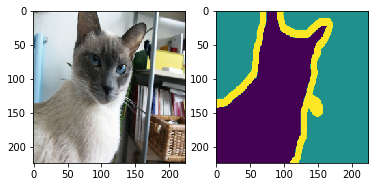

In [11]:
for img,anno in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.subplot(1,2,2)
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))
    plt.imshow(tf.squeeze(anno[0])) 
    plt.show()

In [12]:
conv_base=tf.keras.applications.VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
 
#out_shape:7 7 512 上采样 
conv_base.layers


In [33]:
##sub_model为测试用
sub_model=tf.keras.models.Model(
    inputs=conv_base.input,
    outputs=conv_base.get_layer('block5_conv3').output,
)

# sub_model.summary()

In [39]:
layer_names=[
    'block3_conv3',#(None, 56, 56, 256) 
    'block4_conv3',#(None, 28, 28, 512)
    'block5_conv3',#(None, 14, 14, 512) 
    'block5_pool'# (None, 7, 7, 512) 
]
layers_outputs=[
    conv_base.get_layer(layer_name).output for layer_name in layer_names
]
multi_model =tf.keras.models.Model(
    inputs=conv_base.input,
    outputs=layers_outputs,
)



In [40]:
multi_model.trainable=False

In [43]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
block3_conv3,block4_conv3,block5_conv3,block5_pool,=multi_model(inputs)

In [42]:
    # 'block3_conv3',#(None, 56, 56, 256) 
    # 'block4_conv3',#(None, 28, 28, 512)
    # 'block5_conv3',#(None, 14, 14, 512) 
    # 'block5_pool'# (None, 7, 7, 512) 



TensorShape([None, 7, 7, 512])

In [49]:
x1=tf.keras.layers.Conv2DTranspose(
    512,
    3,
    strides=2, #这使得图像变大
    padding='same',
    activation='relu'
)(block5_pool)
#增加卷积进一步提取特征
x1=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x1)
print(x1.shape)



TensorShape([None, 14, 14, 512])

In [51]:
x2=tf.add(x1,block5_conv3)
x2=tf.keras.layers.Conv2DTranspose(
    512,
    3,
    strides=2, #这使得图像变大
    padding='same',
    activation='relu'
)(x2 )
x2=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x2)
print(x2.shape)



TensorShape([None, 14, 14, 512])

In [56]:
x3=tf.add(x2, block4_conv3)
x3=tf.keras.layers.Conv2DTranspose(
    256,
    3,
    strides=2, #这使得图像变大
    padding='same',
    activation='relu'
)(x3)
x3=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x3)
print(x3.shape)

(None, 56, 56, 256)


In [58]:
x4=tf.add(x3,block3_conv3)
print(x4.shape)

(None, 56, 56, 256)


In [59]:
x5=tf.keras.layers.Conv2DTranspose(
    128,
    3,
    strides=2, #这使得图像变大
    padding='same',
    activation='relu'
)(x4)
x5=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x5)
print(x5.shape)

(None, 112, 112, 128)


In [61]:
pred=tf.keras.layers.Conv2DTranspose(
    3,
    3,
    strides=2, #这使得图像变大
    padding='same',
    activation='softmax'
)(x5)
print(pred.shape)

(None, 224, 224, 3)


In [62]:
model=tf.keras.models.Model(
    inputs=inputs,
    outputs=pred
)



In [65]:
tf.keras.utils.plot_model(model,to_file='./图像语义分割模型图.png')


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [66]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['acc']
)



In [68]:
his=model.fit(
    dataset_train,
    epochs=5,
    steps_per_epoch=train_count//BATCH_SIZE,
    validation_data=dataset_test,
    validation_steps=test_count//BATCH_SIZE
)

Train for 92 steps, validate for 23 steps
Epoch 1/5
92/92 [==============================] - 88s 959ms/step - loss: 0.3017 - acc: 0.8764 - val_loss: 0.2944 - val_acc: 0.8804

In [71]:
his.history

{'loss': [0.3016638111161149,
  0.2797561231190744,
  0.2586221743537032,
  0.24755743324108745,
  0.23196277427284615],
 'acc': [0.87640154, 0.88513255, 0.89307594, 0.8973607, 0.9030452],
 'val_loss': [0.2943965611250504,
  0.3155359392580779,
  0.29419181787449383,
  0.28515131706776825,
  0.28195266490397247],
 'val_acc': [0.88043094, 0.87339747, 0.8829823, 0.8864263, 0.8871902]}

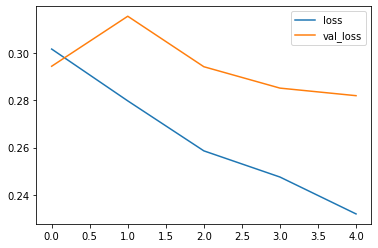

In [72]:
plt.plot(his.epoch, his.history.get('loss'),label='loss')
plt.plot(his.epoch, his.history.get('val_loss'),label='val_loss')
plt.legend()


In [74]:
model.save('./model/fcn.h5')

In [75]:
num = 3

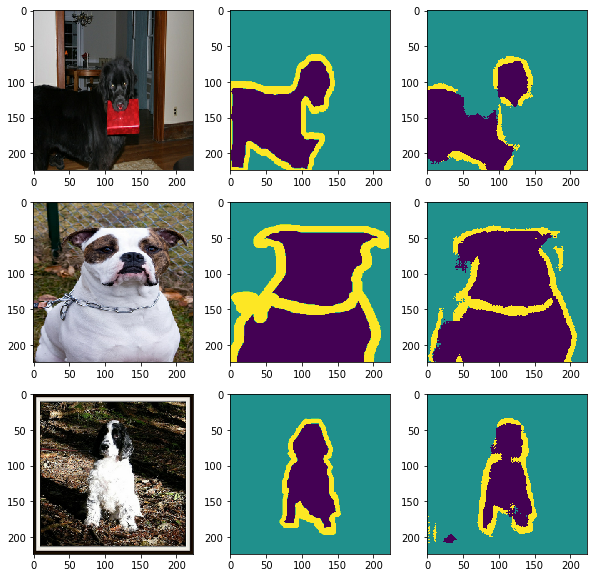

In [77]:
for image, mask in dataset_test.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(image[i])
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.squeeze(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.squeeze(pred_mask[i]))